In [1]:
import sys 
sys.path.append('../')
import torch 
from dataset import load_dataset_1d, reference_test
from utils import rl2_error
import matplotlib.pyplot as plt
from mlmm import SingularSmoothKernelMLMM_full, SpectralModel

In [2]:
l = 13 # number of level, total number of points is 2^l-1
k = 3 # number of corase level
m = 7 # local range for correction
rank = 4 # rank of low-rank model
order = 2 # order of interpolation/restriction

In [3]:
task_nm = 'cosine'
batch_size = 20
upath = '/workdir/MLFormer/data/kernel_estimation/grf1d_N2000_s8193_m0_gamma1_tau1_sigma1_dirichlet.mat'
wpath = f'/workdir/MLFormer/data/kernel_estimation/{task_nm}_8193.npy'
train_loader, test_loader, Khh, xh, h = load_dataset_1d(task_nm, upath, wpath, bsz=batch_size)

In [4]:
l = 13 # number of level, total number of points is 2^l-1
k = 3 # number of corase level
m = 7 # local range for correction
order = 2 # order of interpolation/restriction
uh, Khh, h, wh_numeric, wh_analytic, xh = reference_test(l, task_nm)
wh_mlmm, KHH, Khh_correction_lst, nbr_idx_lst, w_bd= SingularSmoothKernelMLMM_full(uh, Khh, h, k, order, m)

In [5]:
for Khhc in Khh_correction_lst:
    print(Khhc[0].shape, Khhc[1].shape)

torch.Size([1, 1, 1025, 8]) torch.Size([1, 1, 1024, 15])
torch.Size([1, 1, 2049, 8]) torch.Size([1, 1, 2048, 15])
torch.Size([1, 1, 4097, 8]) torch.Size([1, 1, 4096, 15])


In [6]:
mlformer = torch.load('../results/cosine/ML-mlp_lowrank/model.pth')

In [7]:
device = torch.device('cuda:0')

In [8]:
mlformer.eval()
with torch.no_grad():
    for u, w in test_loader:
        u, w = u.to(device), w.to(device)
        w_, KHH_, Khhc_ = mlformer(u)

In [9]:
rl2_error(w_[-1][:,:,1:-1], w[:,:,1:-1])

tensor(0.0020, device='cuda:0')

In [10]:
w[:,:,1:-1].shape

torch.Size([20, 1, 8191])

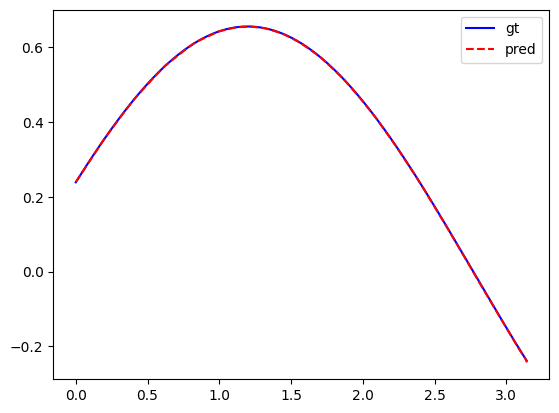

In [11]:
plt.plot(xh[0,0], w.cpu()[4,0], '-b', label='gt')
plt.plot(xh[0,0], w_[-1][4,0].detach().cpu(), '--r', label='pred')
plt.legend()

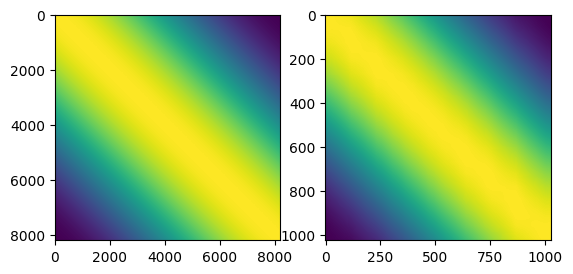

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(Khh[0,0], vmin=-1, vmax=1)
ax2.imshow(KHH_.cpu(), vmin=-1, vmax=1)

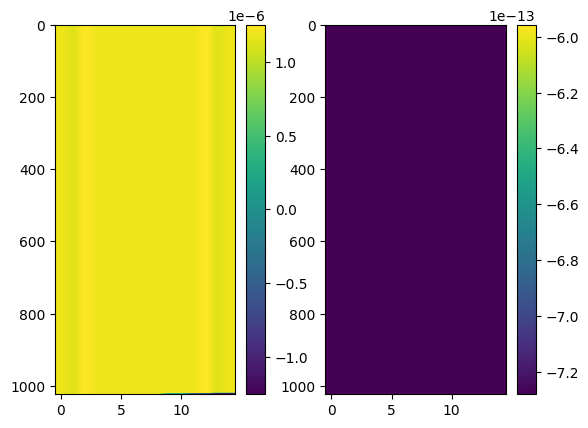

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2)
pcm1 = ax1.imshow(Khh_correction_lst[0][1][0,0], aspect='auto')
pcm2 = ax2.imshow(Khhc_[0][1].cpu(), aspect='auto')
fig.colorbar(pcm1, ax=ax1)
fig.colorbar(pcm2, ax=ax2)